### Monte Carlo Methods
The implementation of blackjack as a monte carlo algorithm

#### Explore BlackJack

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

In [14]:
from plot_utils import plot_blackjack_values, plot_policy

Matplotlib is building the font cache; this may take a moment.


Let's explore the Blackjack environment

In [2]:
env = gym.make('Blackjack-v1')

In [3]:
print(env.observation_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))


In [4]:
print(env.action_space)

Discrete(2)


In [5]:
print(env.action_space)

Discrete(2)


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

##### Blackjack with a random policy. Here the agent interacts with the environment and plays this game for 5 times

In [6]:
num_episodes = 5
for i_episode in range(num_episodes):
    state = env.reset() # Resets the environment to an initial state and returns an initial observation.
    while True:
        print('Starting State: ', state)
        action = env.action_space.sample() 
        # Randomly sample an element of this space. Can be uniform or non-uniform sampling based on boundedness of space.
        # Here the actionspace is discrete with only two values 0, 1
        
        state, reward, done, info = env.step(action)
        # Run one timestep of the environment's dynamics. When end of episode is reached, you are responsible for calling `reset()` to reset this environment's state.
        # Input Args : An action provided by agent
        # Returns - 
        # Observation : agent's observation of the current environment
        # reward (float) : amount of reward returned after previous action
        # done (bool): whether the episode has ended, in which case further step() calls will return undefined results
        # info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        
        if done:
            print('Agents observations about the environment: ', state)
            print("End Game! Reward: ", reward)
            print("You Won :)") if reward > 0 else print("You lost :(")
            print("Other information: ", info)
            print("\n")
            break

Starting State:  (6, 8, False)
Starting State:  (16, 8, False)
Agents observations about the environment:  (16, 8, False)
End Game! Reward:  1.0
You Won :)
Other information:  {}


Starting State:  (16, 9, False)
Agents observations about the environment:  (16, 9, False)
End Game! Reward:  -1.0
You lost :(
Other information:  {}


Starting State:  (8, 3, False)
Agents observations about the environment:  (8, 3, False)
End Game! Reward:  -1.0
You lost :(
Other information:  {}


Starting State:  (11, 8, False)
Agents observations about the environment:  (11, 8, False)
End Game! Reward:  -1.0
You lost :(
Other information:  {}


Starting State:  (20, 5, False)
Starting State:  (21, 5, False)
Agents observations about the environment:  (26, 5, False)
End Game! Reward:  -1.0
You lost :(
Other information:  {}




#### Monte Carlo (MC) prediction
Here we will write the implemantation of MC prediction for estimating the Action-Value function. 

We will begin by investigating a policy where the player almost always sticks if the sum of her cards exceeds 18. In particular, she selects action STICK with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action HIT with 80% probability. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
# The below function samples as episode using the above policy

def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p = probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [8]:
# Let's play blackjack with this policy-
for i in range(5):
    print(generate_episode_from_limit_stochastic(env))

[((20, 7, False), 0, 1.0)]
[((12, 2, False), 1, 0.0), ((14, 2, False), 1, 0.0), ((18, 2, False), 1, -1.0)]
[((12, 8, False), 1, 0.0), ((18, 8, False), 1, -1.0)]
[((20, 7, False), 1, -1.0)]
[((12, 8, False), 1, 0.0), ((17, 8, False), 0, 0.0)]


Now we will use this policy mentioned above and estimate the corresponding Action Value Function Q(s,a). We will implement First-Visit MC prediction. In case of Blackjack both are equivalent as we will never come back to the same state.

The algorithm has four arguments -
* env : Instance of an OpenAI gym environment
* num_episodes : This is the number of episodes that are generated through agent-environment interaction
* generate_episodes : This is a function that returns an episode of interaction
* gamma : This is a discount rate, must be a value between 0 and 1 (both inclusive). by default it is 1

The algorithm returns -
* Q : This is a dictionary (of one-dimensional array) where Q[s][a] is estimated action value corresponding to state s and action a.

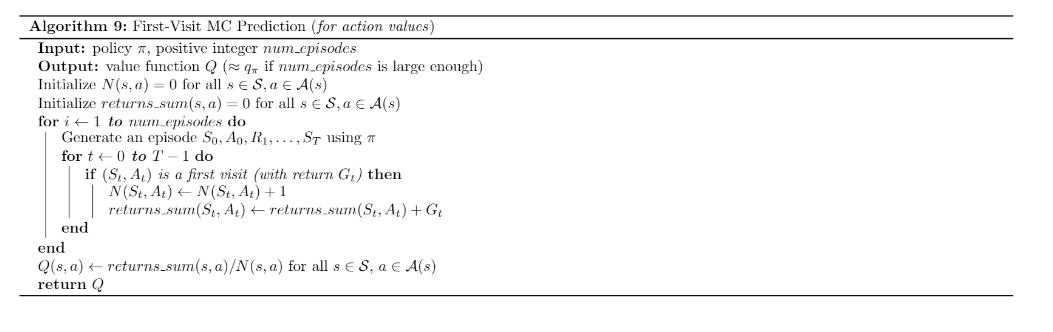

In [9]:
from IPython import display
display.Image("./MC_firstVisit.PNG")

In [10]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma = 1.0):
    # initialization
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over all the episodes -
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # discounting
        discounts = np.array([gamma**i for i in range(len(rewards) + 1)])
        
        # update the sum of the returns, number of visits, and action-value function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            # note for blackjack first visit and every visit MC is equivalent so we are not checking if it is the first visit-
            returns_sum[state][actions[i]] += sum(rewards[i:] * discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]] # averaging across all the episodes
    return Q

In [11]:
# Let's compute action-value function estimate Q using 500,000 episodes.
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

In [12]:
len(Q)

280

In [13]:
keys = [(21, 10, True), (10, 7, False), (21, 9, False)]
for key in keys:
    print(key, Q[key])

(21, 10, True) [ 0.91910621 -0.1158366 ]
(10, 7, False) [-0.50802139 -0.03856383]
(21, 9, False) [ 0.93646532 -1.        ]


There are in total 280 states got created after playing the blackjack for half a million times (episodes). The value of the Q is the estimated action-value function.
So, let's look at few states to interpret the results -
* For (21, 10, True) i.e. Value of my hand : 21 ---- value of dealer's face up card : 10, ---- the ace is "usable" i.e. the value of "A" is 11 and not 1
The estimated value of Action : 0 is 0.91 i.e. STICK (don't take more cards).

* For (10, 7, False) i.e. Value of my hand : 10 ---- value of dealer's face up card : 7, ---- the ace is "not usable" i.e. the value of "A" is 1 and not 11
The estimated value of Action : 0 is -0.43 i.e. STICK (don't take more cards) and 1 is -0.06 i.e. HIT (take the next card from the deck). Here, the later is greater than the former. Hence the estimated action is to HIT.

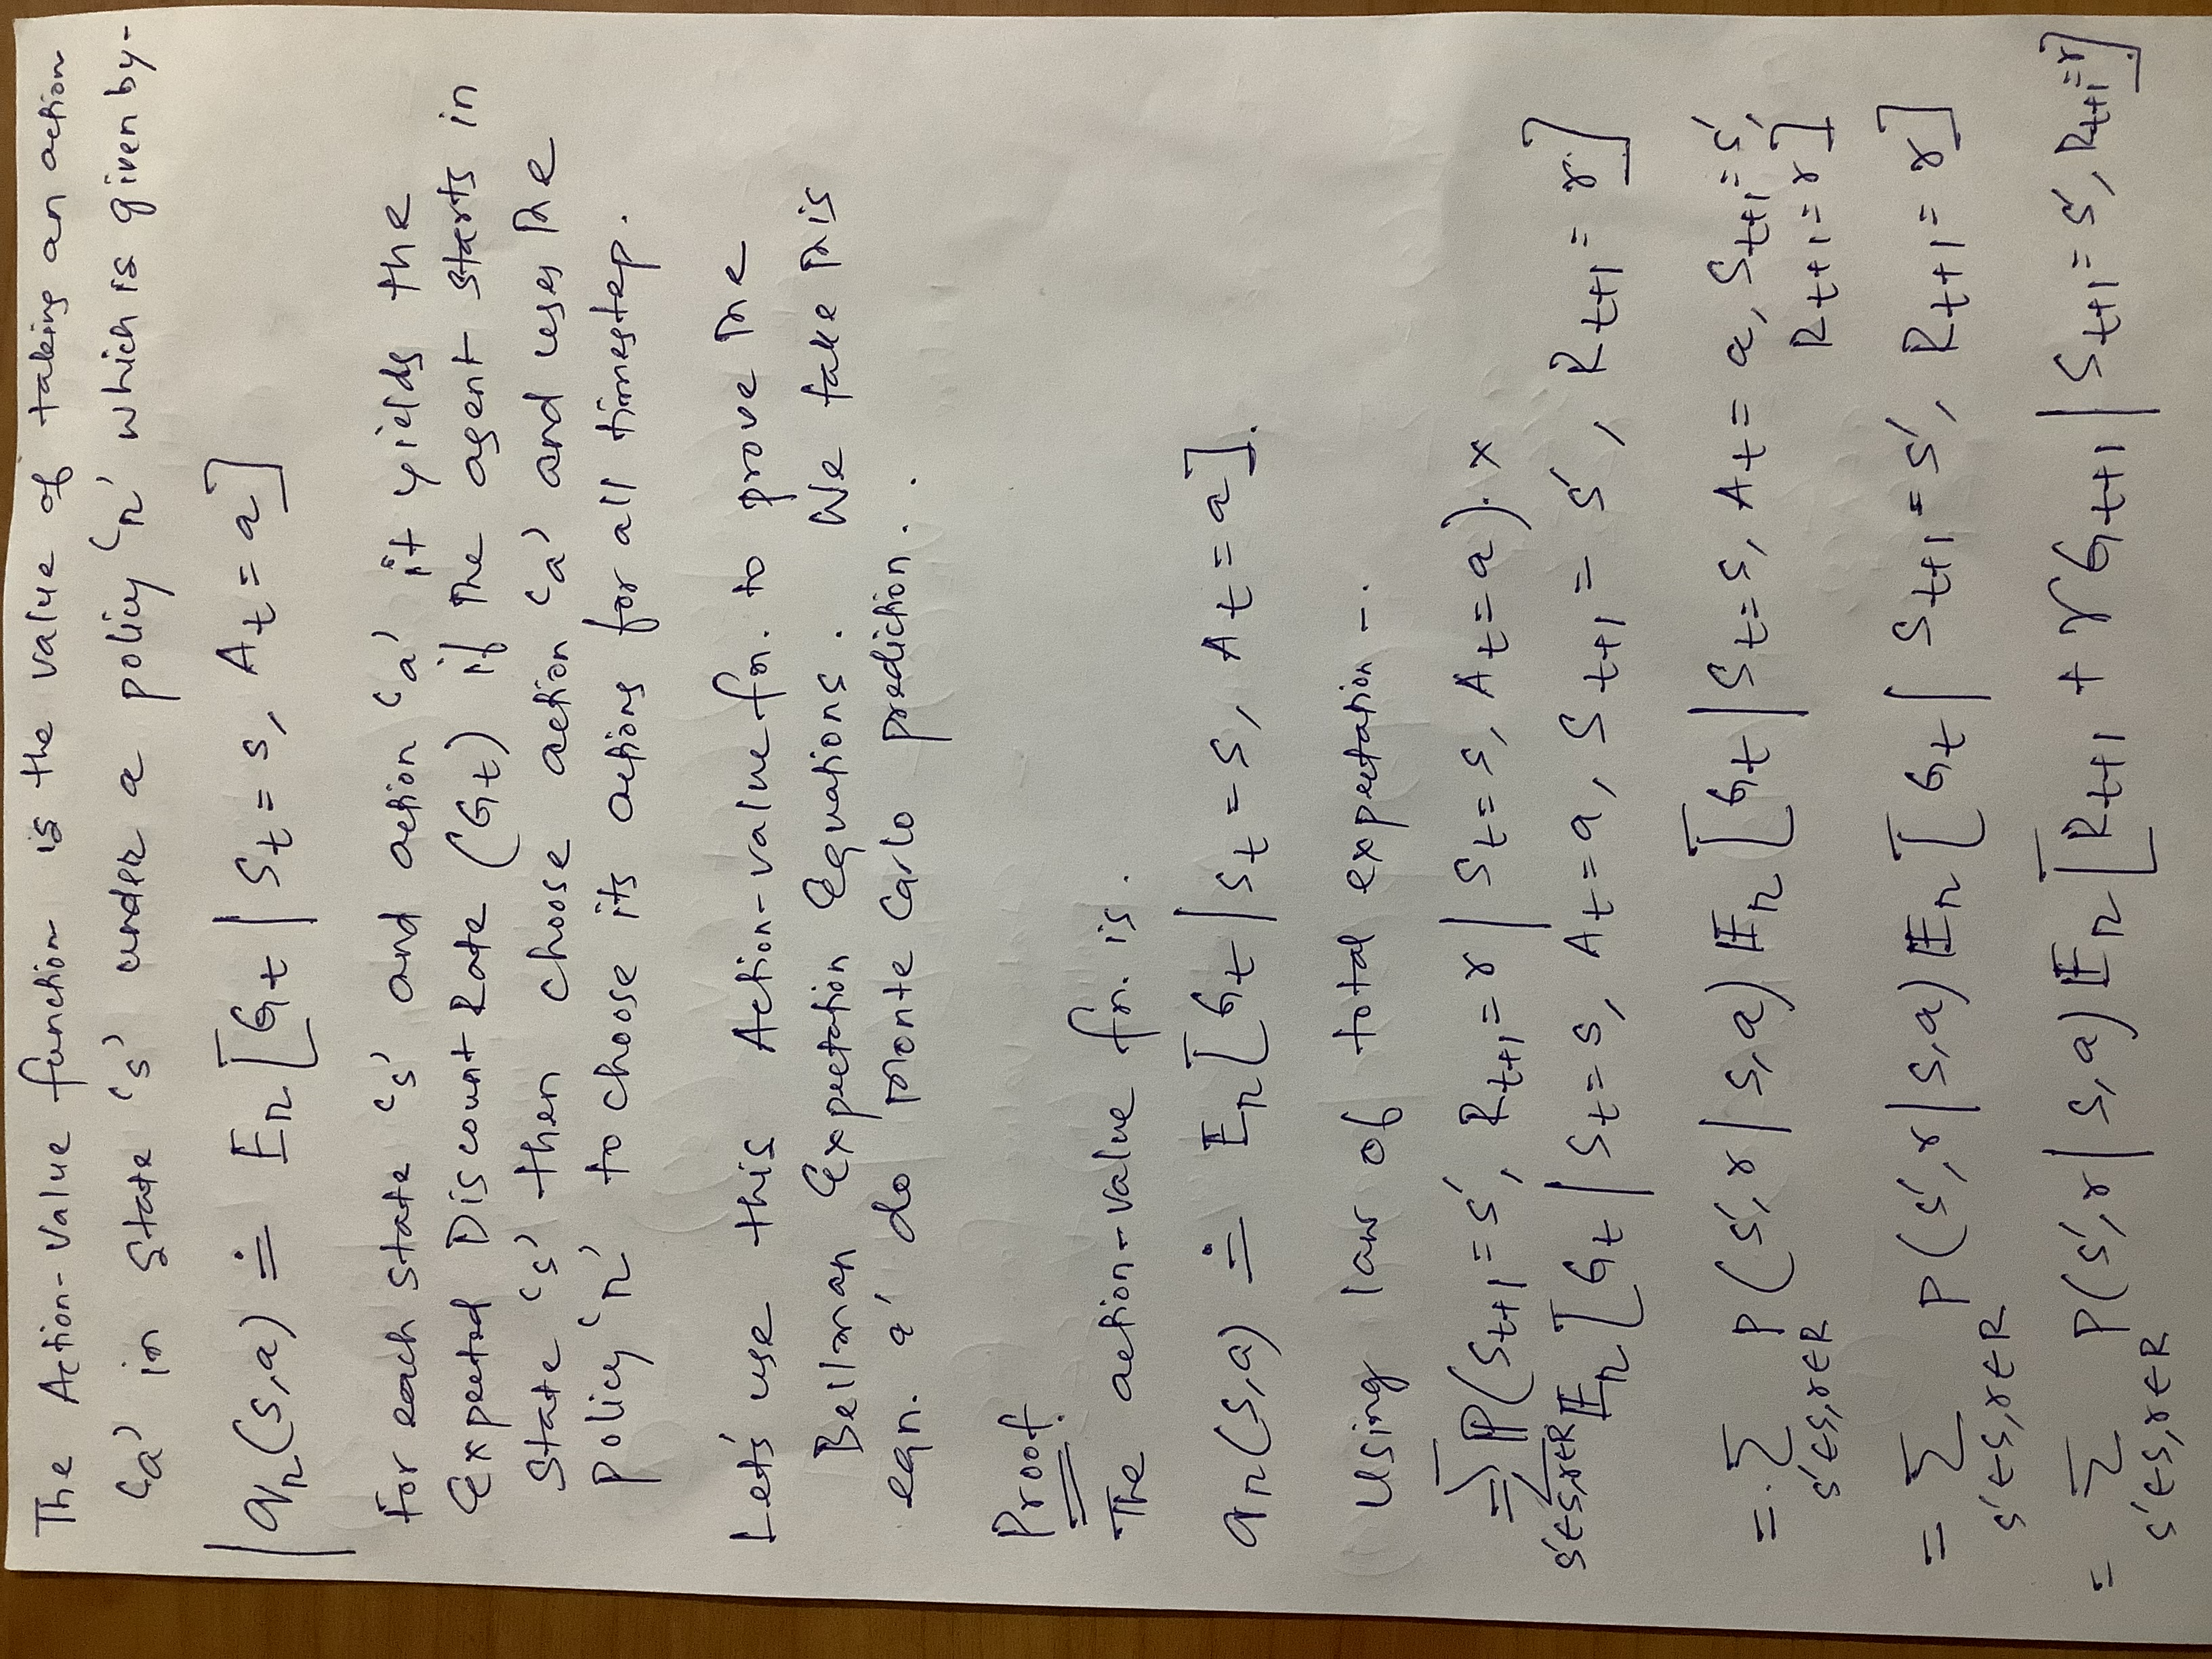

In [14]:
display.Image("./action_value_fn_1.jpg", width=400)

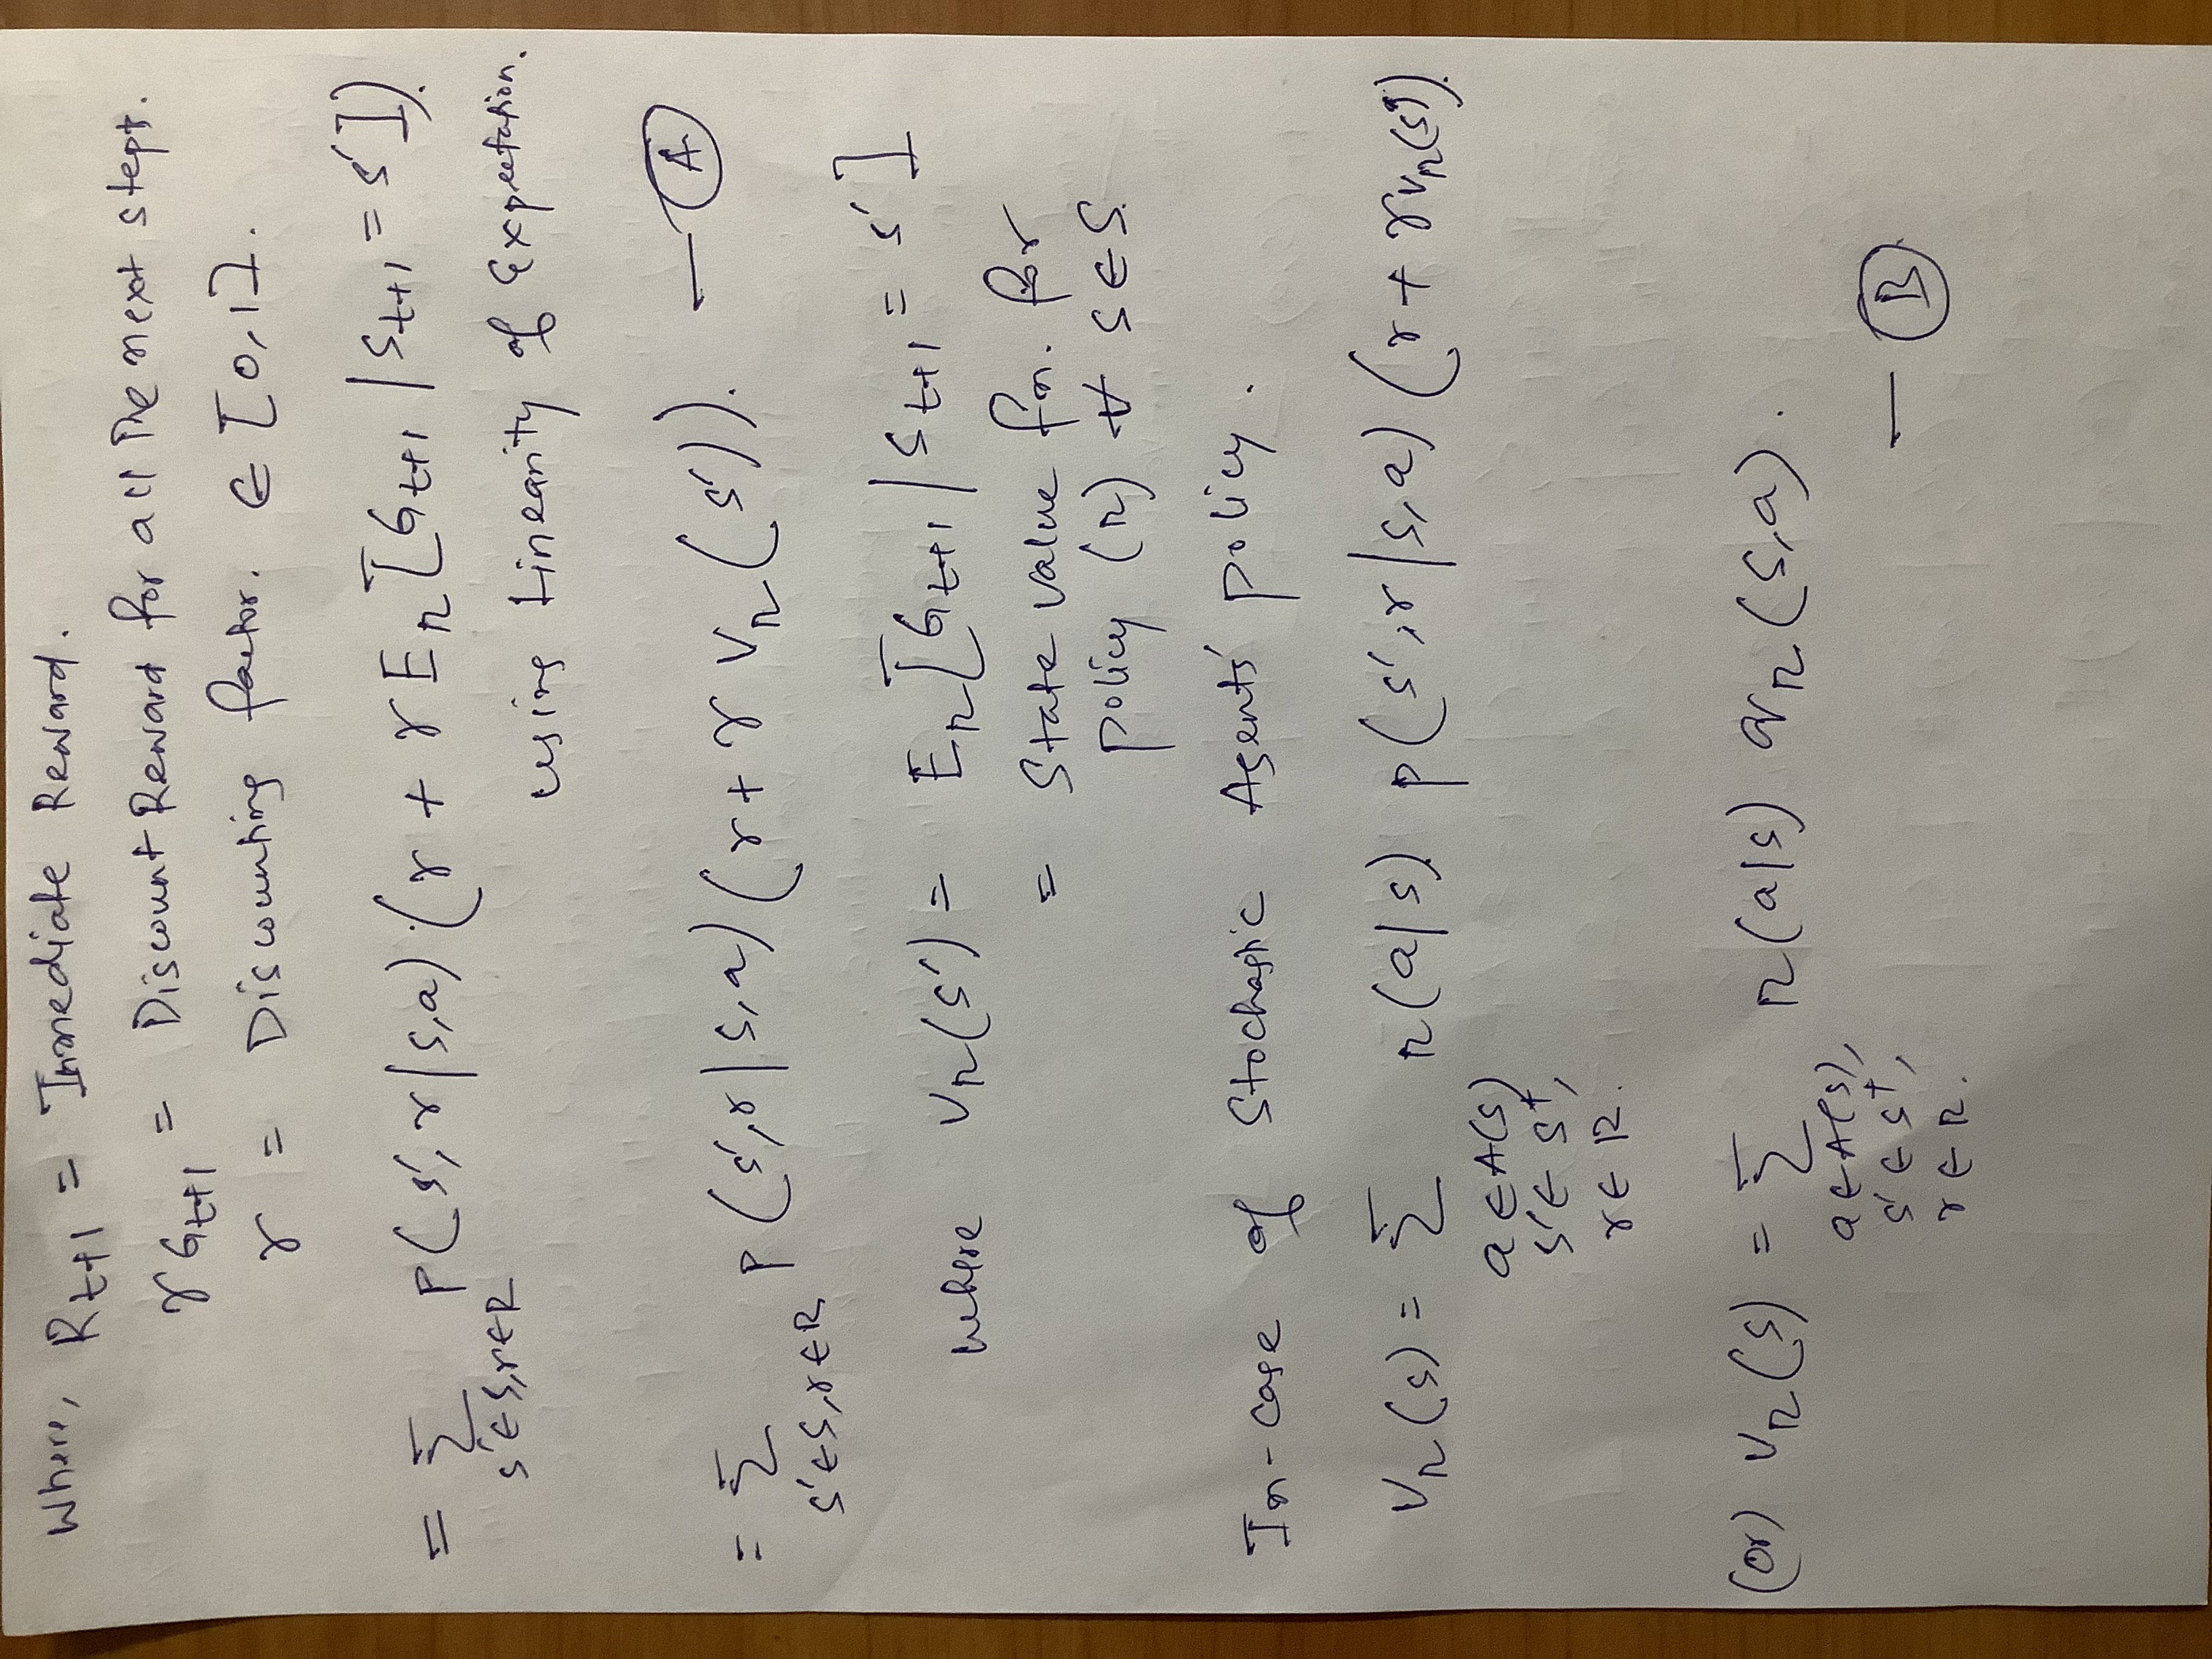

In [15]:
display.Image("./action_value_fn_2.jpg", width=400)

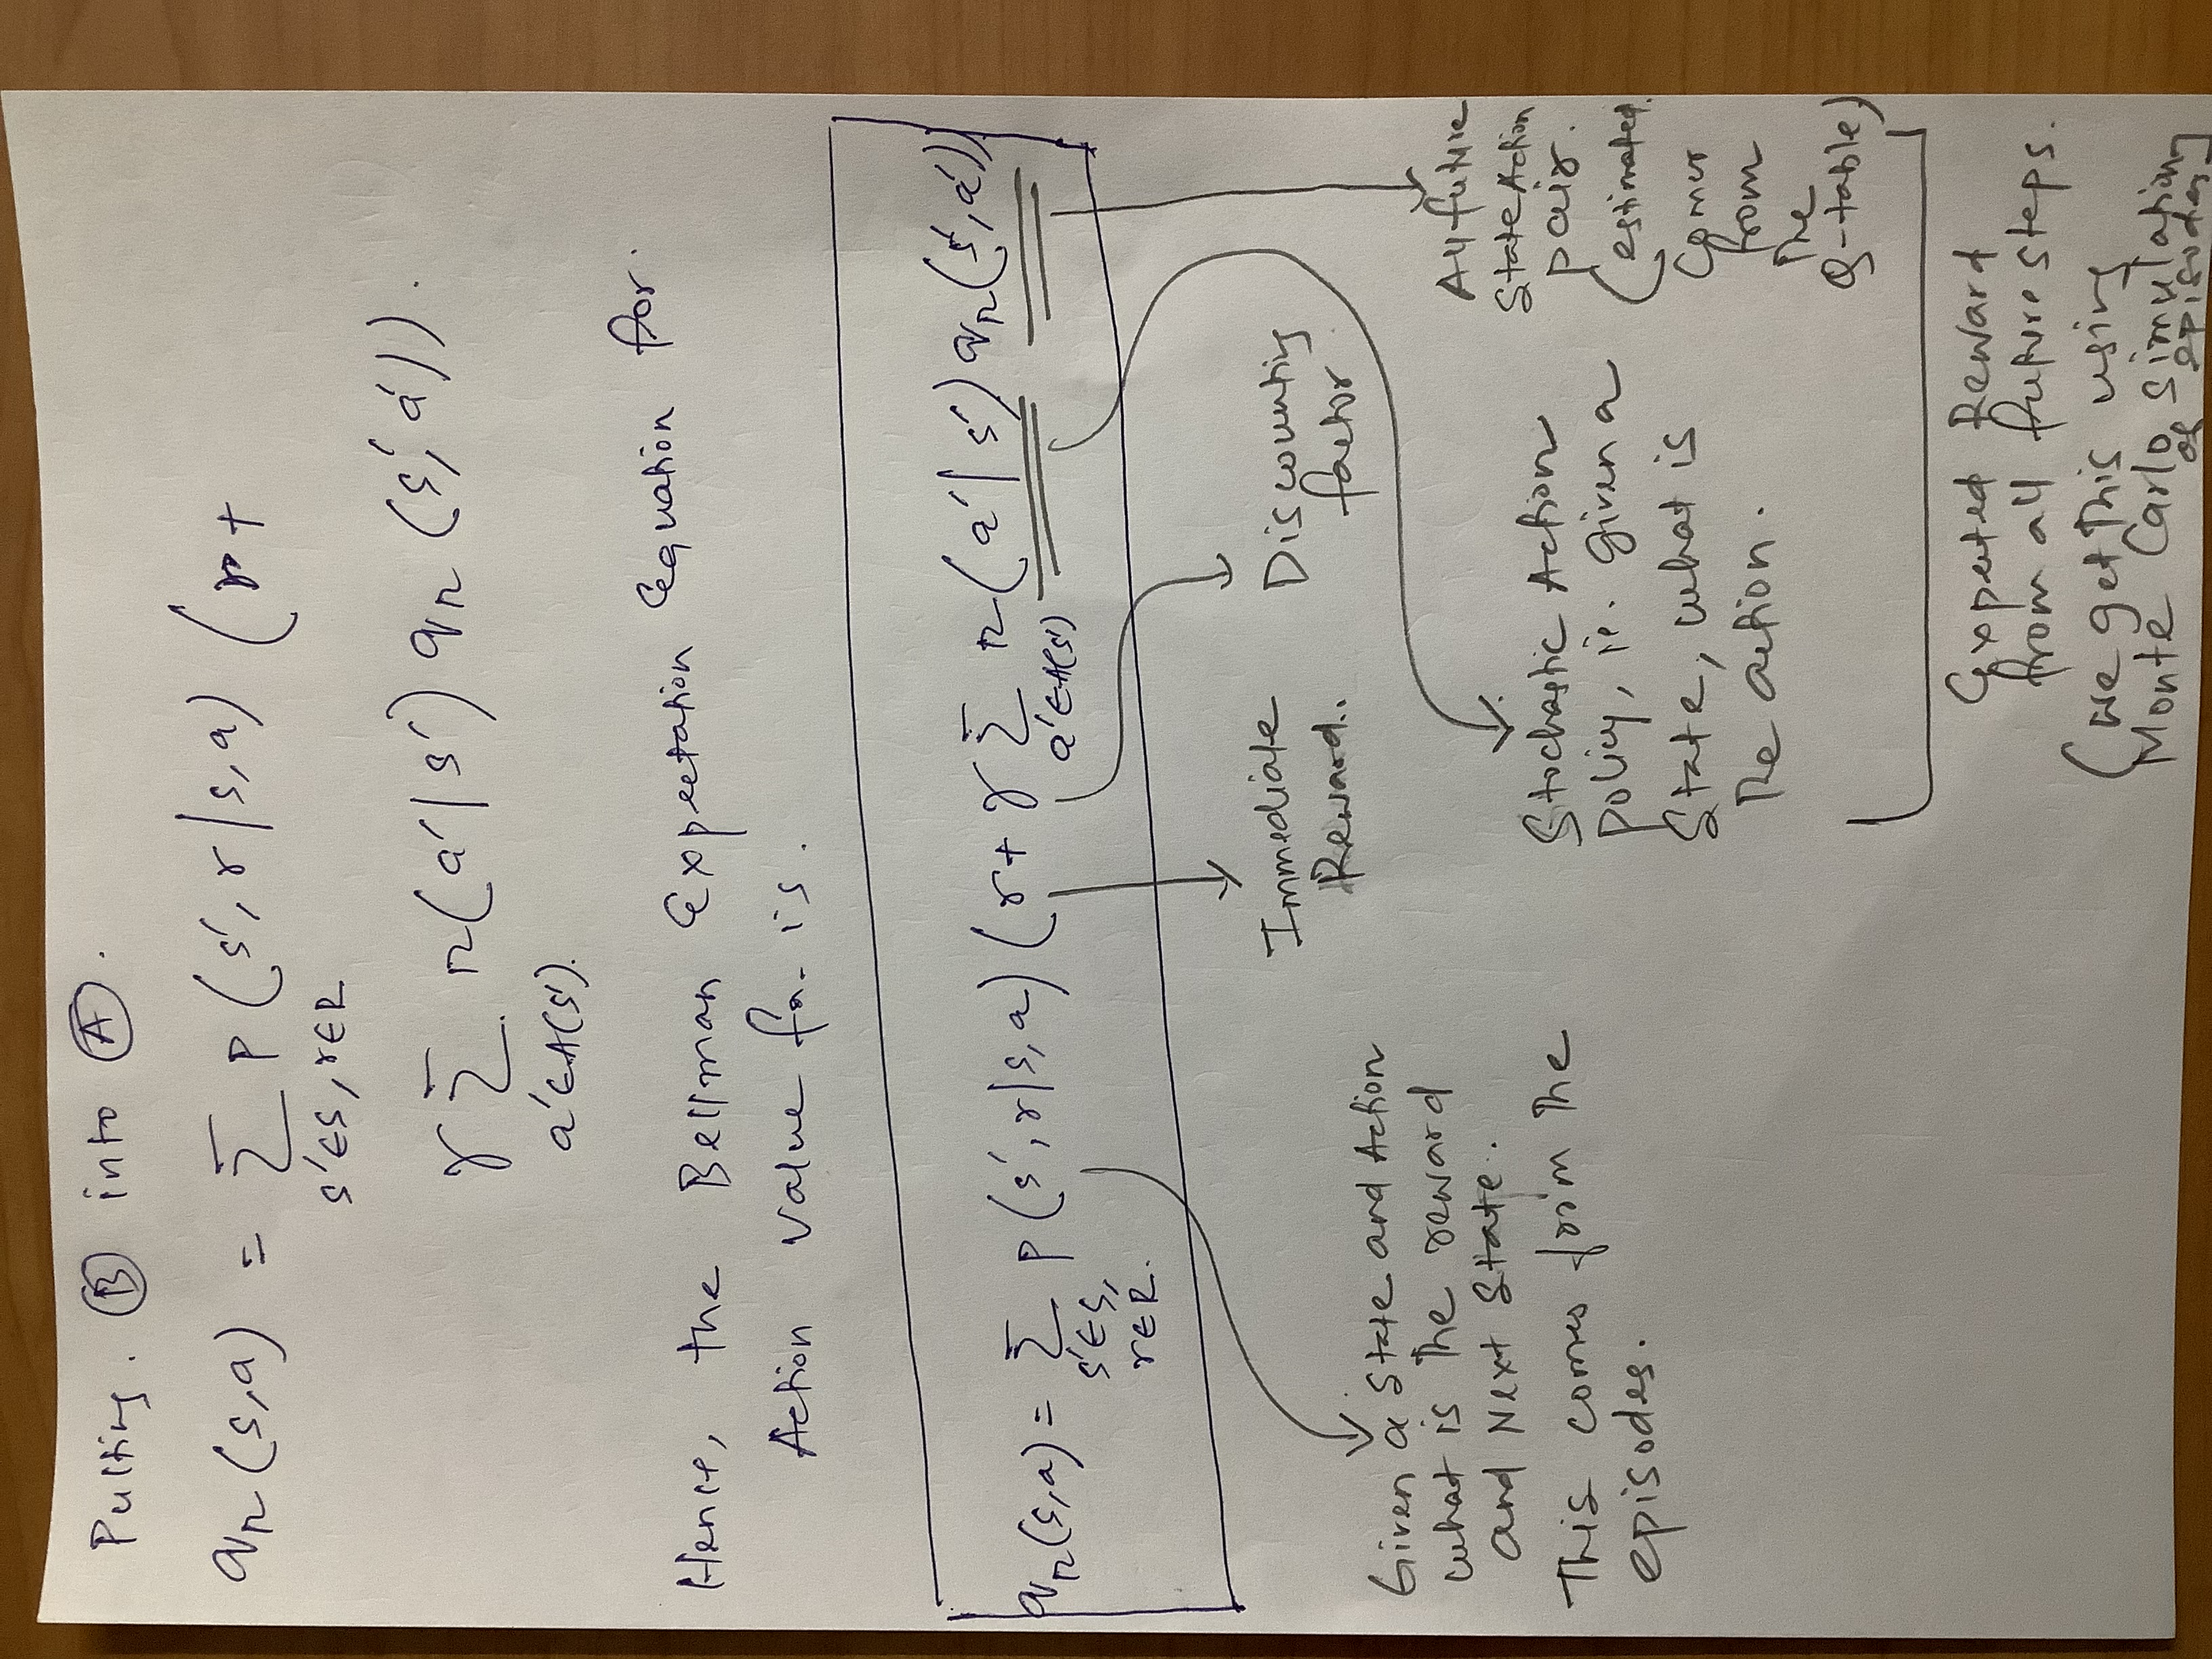

In [16]:
display.Image("./action_value_fn_3.jpg", width=400)

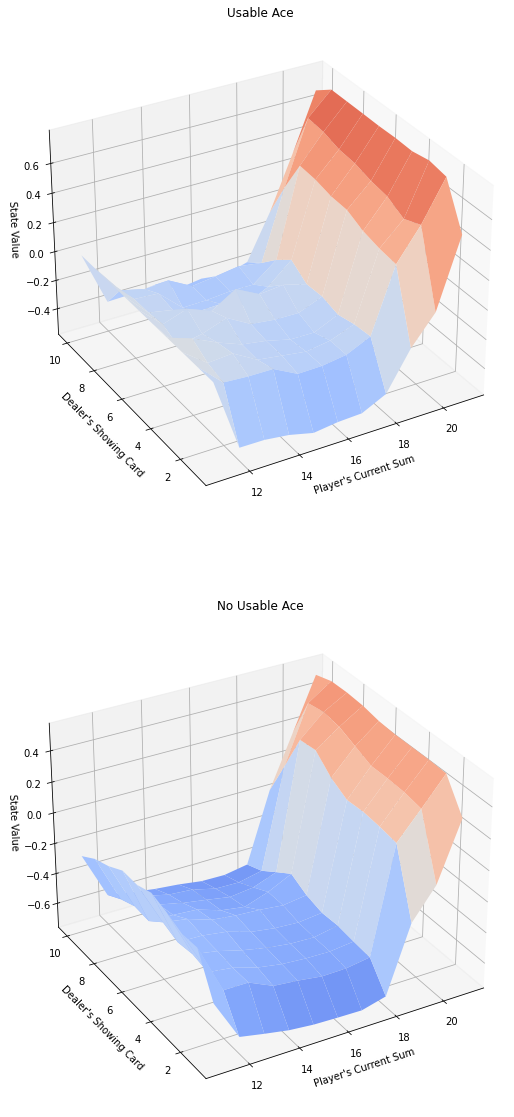

In [15]:
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)